<a href="https://colab.research.google.com/github/130ndim/dul_2021/blob/hw10/Homework/hw10/Homework10_selfsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 339 (delta 100), reused 82 (delta 60), pack-reused 163
Receiving objects: 100% (339/339), 55.19 MiB | 41.49 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=25374 sha256=16695ab01beafa128cea1a5dcc156b4dcdf61865b90ac4e29b53d59fce2f8269
  Stored in directory: /tmp/pip-ephem-wheel-cache-zam6v3ri/wheels/55/59/29/0fb1c6356521

In [45]:
from dul_2021.utils.hw10_utils import *

import random
import numpy as np

import torch
from torch import Tensor, nn, optim
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms as T

from tqdm.auto import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [46]:
def drop_center(img: Tensor, n: int = 14):
    h, w = img.size(-2), img.size(-1)
    mask = img.new_ones(1, 1, h, w)
    hc, wc = h // 2, w // 2
    mask[..., hc - n // 2:hc + n // 2, wc - n // 2:wc + n // 2] = 0
    return img * mask, 1 - mask

In [47]:
class Encoder(nn.Module):
    def __init__(self, ld):
        super().__init__()
        self._seq = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.ReLU(),
        )
        self._lin = nn.Linear(4 * 4 * 128, ld)

    def forward(self, x):
        x = self._seq(x)
        x = x.view(-1, 4 * 4 * 128)
        x = self._lin(x)
        return x


class Decoder(nn.Module):
    def __init__(self, ld):
        super().__init__()
        self._lin = nn.Linear(ld, 4 * 4 * 128)
        self._seq = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self._lin(z)
        x = x.view(-1, 128, 4, 4)
        x = self._seq(x)

        return x

class Classifier(nn.Module):
    def __init__(self, n_out: int = 1):
        super().__init__()
        self._seq = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.ReLU(),
        )
        self._out = nn.Sequential(
            nn.Linear(4 * 4 * 128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_out)
        )

    def forward(self, x):
        x = self._seq(x)
        x = x.view(-1, 4 * 4 * 128)
        x = self._out(x)
        return x

In [48]:
class CAE(nn.Module):
    def __init__(self, ld: int = 64, n_drop: int = 14, clf_freq: int = 10):
        super().__init__()
        self._ld = ld
        self._n_drop = n_drop
        self._clf_freq = clf_freq

        self._enc = Encoder(ld)
        self._dec = Decoder(ld)
        self._clf = Classifier()

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: Tensor) -> Tensor:
        return self._dec(self._enc(x))

    def _compute_losses(self, x):
        masked, mask = drop_center(x, self._n_drop)

        x_hat = self(masked)

        rec_loss = (mask * F.mse_loss(x_hat, x, reduction='none')).mean()
        d_hat = self._clf(x_hat)
        ae_loss = rec_loss + F.binary_cross_entropy_with_logits(d_hat, torch.ones_like(d_hat))

        clf_loss = (
                F.binary_cross_entropy_with_logits(self._clf(x), torch.ones_like(d_hat)) +
                F.binary_cross_entropy_with_logits(self._clf(x_hat.detach()), torch.zeros_like(d_hat))
        )

        return ae_loss, clf_loss

    def fit(self, train_data, n_epochs=20, lr=1e-3, bs=256, lr_gamma=0.1, n_decays=1):
        dl = data.DataLoader(train_data, batch_size=bs, shuffle=True, drop_last=True)

        opt = optim.Adam(self.parameters(), lr=lr)
        sch = optim.lr_scheduler.StepLR(opt, max(n_epochs // (n_decays + 1), 1), lr_gamma)

        ae_losses, clf_losses = [], []

        bar = tqdm(total=n_epochs * len(dl), desc='Training')

        res_dict = {}

        for _ in range(n_epochs):

            res_dict.update({'lr': sch.get_last_lr()[0]})
            for i, batch in enumerate(dl):
                batch, _ = batch

                ae_loss, clf_loss = self._compute_losses(batch.to(self.device))

                loss = ae_loss
                if i % self._clf_freq == 0:
                    loss += clf_loss

                opt.zero_grad()
                loss.backward()
                # utils.clip_grad_norm_(self._clf.parameters(), 0.1)
                opt.step()

                ae_losses.append(ae_loss.item())
                clf_losses.append(clf_loss.item())

                res_dict.update({'ae_loss': ae_losses[-1], 'clf_loss': clf_losses[-1], 'loss': loss.item()})

                bar.update(1)
                bar.set_postfix(res_dict)

            sch.step()

        return np.array(ae_losses), np.array(clf_losses)

    @torch.no_grad()
    def test(self, batch: Tensor) -> Tensor:
        batch = batch.to(self.device)
        masked, _ = drop_center(batch, self._n_drop)

        return torch.cat([masked, self(masked), batch], dim=0)

In [49]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    model = CAE()
    model.to(DEVICE)

    ae_losses, clf_losses = model.fit(train_data, lr_gamma=0.5, n_decays=3)

    test_batch = torch.stack([test_data[i][0] for i in range(10)], dim=0)

    out = model.test(test_batch).cpu()

    return ae_losses, clf_losses, out

Training:   0%|          | 0/4680 [00:00<?, ?it/s]

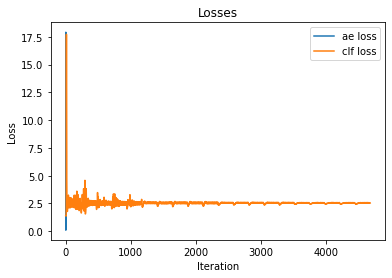

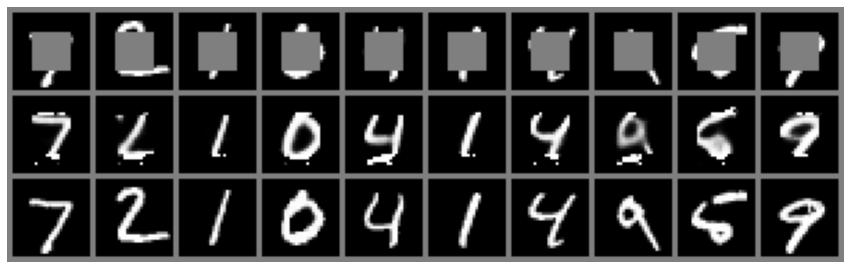

In [50]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [76]:
class MNISTWrapper:
    def __init__(self, dataset, transform=None):
        self._dataset = dataset
        self._transform = transform

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, idx):
        item, _ = self._dataset[idx]
        if self._transform is not None:
            item = self._transform(item)
        return item


class RandomRotateWithLabel:
    def __init__(self):
        self._transforms = [T.RandomRotation((90 * i, 90 * i)) for i in range(4)]

    def __call__(self, x):
        idx = random.randint(0, 3)
        y = torch.tensor([idx])
        x = self._transforms[idx](x)
        return x, y

In [78]:
from os import pread
class AnglePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self._clf = Classifier(4)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: Tensor) -> Tensor:
        return self._clf(x)

    def fit(self, train_data, n_epochs=20, lr=1e-3, bs=256, lr_gamma=0.1, n_decays=1):
        train_data = MNISTWrapper(train_data, transform=RandomRotateWithLabel())
        dl = data.DataLoader(train_data, batch_size=bs, shuffle=True, drop_last=True)

        opt = optim.Adam(self.parameters(), lr=lr)
        sch = optim.lr_scheduler.StepLR(opt, max(n_epochs // (n_decays + 1), 1), lr_gamma)

        accs, losses = [], []

        bar = tqdm(total=n_epochs * len(dl), desc='Training')

        res_dict = {}

        for _ in range(n_epochs):
            acc = 0
            res_dict.update({'lr': sch.get_last_lr()[0]})
            for i, batch in enumerate(dl):
                x, y = batch
                x, y = x.to(self.device), y.ravel().to(self.device)

                pred = self(x)

                loss = F.cross_entropy(pred, y.ravel())

                acc += (pred.argmax(-1) == y).sum().item()

                opt.zero_grad()
                loss.backward()
                # utils.clip_grad_norm_(self._clf.parameters(), 0.1)
                opt.step()

                losses.append(loss.item())

                res_dict.update({'loss': loss.item()})

                bar.update(1)
                bar.set_postfix(res_dict)
            
            accs.append(acc / bs / len(dl))
            res_dict.update({'acc': accs[-1]})
            sch.step()

        return np.array(losses), np.array(accs)

In [84]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """
    model = AnglePredictor()
    model.to(DEVICE)

    losses, accs = model.fit(train_data, 10, lr=1e-3, lr_gamma=0.5, n_decays=3)

    return losses, accs

Training:   0%|          | 0/2340 [00:00<?, ?it/s]

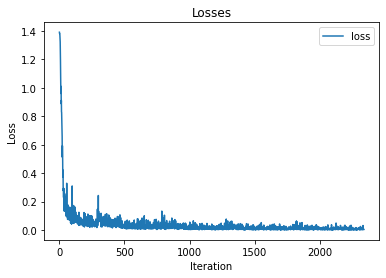

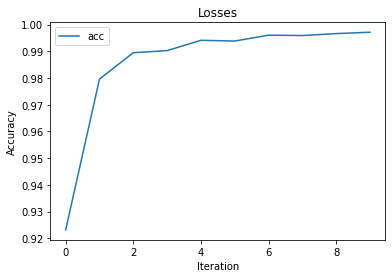

In [85]:
q2_results(q2)